# Link sparsification Figures 5, 6, 7

Latest update (Sep. 3, 2025): 
- update pandas DataFrame operations for python3.10
- adjust fonts in `matplotlib` and `seaborn` for IEEE TWC final version (Accepted fonts: Symbol, Helvetica, Arial, Time New Roman)

In [1]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from test_utils import *

/tmp/ipykernel_94047/2763557719.py:36: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "ps.fonttype": 42,      # embed TrueType in EPS
    "pdf.fonttype": 42,
    "savefig.transparent": False,  # no page transparency (EPS can't do alpha)
    "legend.framealpha": 1.0,      # if you use legends, make them opaque
})

# Analysis of overhead results

In [3]:
# Test Configurations
# graphtype = 'ER'
# case_date = '2023-03-15'

# Below is the configuration for first submission to IEEE TWC
graphtype = 'BA'
case_date = '2023-03-22'
dataset = '{}_Graph_Uniform_GEN24_test2'.format(graphtype)
optlist = [0, 5, 9] # Initial submission

# IEEE TWC major revision, adding one data point m=40
# case_date = '2025-01-18'
# dataset = '{}_Graph_Uniform_GEN24_m40'.format(graphtype)
# optlist = [7, 5, 9] # Major revision

algolist = ['Greedy', 'single', 'single-self', 'single-gcn', 'DGCN-LGS']

configurations = {
    'deadline': {
        'cases': 'cases_{}_deadline_load-0.03_{}.csv'.format(dataset, case_date),
#         'token': 'SPADL1',
        'token': 'ASGDF1v7',
#         'token': 'SPAFooF1v7',
#         'token': 'SPAFooF1v9',
        'level': 0.66,
#         'level': 0.3,
#         'level': 0.69,
        'load': 0.03,
        'postfix': '',
    },
    'overhead': {
        'cases': 'cases_{}_overhead_load-0.03_{}.csv'.format(dataset, case_date),
#         'token': 'ASGDF1v7',
#         'token': 'SPAFooF1v7',
#         'token': 'SPAOH1',
        'token': 'SPAFooF1v9',
#         'level': 0.56,
#         'level': 0.45,
        'level': 0.61,
#         'load': 0.08,
        'load': 0.03,
        'postfix': '',
    },
    'qcsma': {
        'cases': 'cases_{}_qcsma_load-0.03_{}.csv'.format(dataset, case_date),
        'token': 'ASGDF1v7',
#         'token': 'SPAFooF1v7',
#         'token': 'SPAQC1',
#         'token': 'SPAFooF1v9',
        'level': 0.75,
#         'level': 0.9,
        'load': 0.03,
        'postfix': '_W-32',
    },
    'csma': {
        'cases': 'cases_{}_qcsma_load-0.03_{}.csv'.format(dataset, case_date),
        'token': 'ASGDF1v7',
#         'token': 'SPAFooF1v7',
#         'token': 'SPAQC1',
#         'token': 'SPAFooF1v9',
        'level': 0.75,
#         'level': 0.9,
        'load': 0.03,
        'postfix': '_W-32',
    },
}

nlayers = [1, 2, 3]

output_dir = './wireless'
experiments = configurations.keys()


greedy_dicts = {
#     'overhead': 'not_exist.csv', #'metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.08_layer-1_level-all_sparsify_overhead_BA_Graph_Uniform_GEN24_test2_SPAOH1.csv',
    'overhead': 'not_exist.csv', #'metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-0.61_sparsify_overhead_BA_Graph_Uniform_GEN24_test2_SPAFooF1v9.csv',
    'deadline': 'not_exist.csv', #'metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-all_sparsify_deadline_BA_Graph_Uniform_GEN24_test2_SPADL1.csv',
    'qcsma': 'not_exist.csv', #'metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-all_sparsify_qcsma_BA_Graph_Uniform_GEN24_test2_W-32_SPAQC1.csv',
    'csma': 'not_exist.csv', #'metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-all_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_SPAQC1.csv',
}

## Load data directly
- For Figures 5: `experiment='deadline'`
- For Figures 6: `experiment='overhead'`
- For Figures 7: `experiment='csma'`

In [4]:
# experiment = 'deadline'
experiment = 'overhead'
# experiment = 'qcsma'
# experiment = 'csma'
level = configurations[experiment]['level']
load = configurations[experiment]['load']
token = configurations[experiment]['token']
cases = configurations[experiment]['cases']
pfix = configurations[experiment]['postfix']


csvname = "./wireless/sparsify_scheduling_{}_level_{:.2f}_{}".format(
    token, 
    level,
    cases
)

# df_cases = pd.read_csv(os.path.join(output_dir, cases), index_col=False)


### Option 1: load data already collected from option 2

In [5]:
# df['name'].replace('Dense-LGS','Dense-Zero', inplace=True)
# df = df.rename(columns={'name': 'policy'})
# df.columns

# IEEE TWC final (Sep 3, 2025)
# save data to files
# df.to_csv('./wireless/sparsify_scheduling_ASGDF1v7_level_0.75_cases_BA_Graph_Uniform_GEN24_test2_csmas_load-0.03_2023-03-22.csv')

# load data for plot
if experiment in ['csma','qcsma']:
    # Figs. 7
    csvname = 'sparsify_scheduling_ASGDF1v7_level_0.75_cases_BA_Graph_Uniform_GEN24_test2_csmas_load-0.03_2023-03-22.csv'
elif experiment == 'deadline':
    # Figs. 5
    csvname = 'sparsify_scheduling_ASGDF1v7_level_0.66_cases_BA_Graph_Uniform_GEN24_test2_deadline_load-0.03_2023-03-22.csv'
elif experiment == 'overhead':
    # Figs. 6
    csvname = 'sparsify_scheduling_SPAFooF1v9_level_0.61_cases_BA_Graph_Uniform_GEN24_test2_overhead_load-0.03_2023-03-22.csv'
else:
    print("{} not supported".format(experiment))

df=pd.read_csv(
    './wireless/'+csvname,
    index_col=0
              )
df

,graph,seed,load,policy,avg_queue_len,50p_queue_len,95p_queue_len,avg_throughput,avg_n_ratio,avg_e_ratio,avg_deg_sp,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree,runtime,avg_slot,N_p,N
0,BA_n100_p0.02_b0_uni.mat,1869282308,0.05,Dense-Zero,2.35725,1.2925,8.0,2.48305,0.99500,0.995000,3.920000,2.725,419.50,176.035,1.000000,3.92,3.690000,1.362316,4.0,100
1,BA_n100_p0.02_b0_uni.mat,1869282308,0.05,Sparse-Stat,17.17970,16.5675,37.0,2.41515,0.07385,0.005230,0.256174,1.020,2.06,14.035,0.314884,3.92,2.164133,1.417028,4.0,100
2,BA_n100_p0.02_b0_uni.mat,1869282308,0.05,Sparse-Stat-self,3.37225,2.6275,10.0,2.48095,0.47400,0.197066,1.610941,2.170,82.97,86.450,0.901578,3.92,3.927062,1.397406,4.0,100
3,BA_n100_p0.02_b10_uni.mat,216729663,0.03,Dense-Zero,1.36015,0.4625,5.0,1.49975,0.99500,0.995000,3.920000,2.715,418.58,175.720,1.000000,3.92,3.622169,1.362563,4.0,100
4,BA_n100_p0.02_b10_uni.mat,216729663,0.03,Sparse-Stat,15.93755,15.4950,34.0,1.42125,0.04530,0.002219,0.154230,0.945,0.87,8.715,0.218206,3.92,2.012046,1.418163,4.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,BA_n500_p0.1_b5_uni.mat,1581004827,0.05,Hybrid-GCN(3),72.67108,62.8125,217.0,1.55239,0.32025,0.159874,30.956912,4.060,8134.28,284.000,0.836141,90.00,116.897985,0.840890,100.0,500
10316,BA_n500_p0.1_b6_uni.mat,4128209110,0.05,Hybrid-GCN(3),64.11721,55.2350,182.0,1.70130,0.28184,0.121507,26.799109,3.910,6265.45,254.280,0.836030,90.00,117.452785,0.922326,100.0,500
10317,BA_n500_p0.1_b7_uni.mat,910224140,0.04,Hybrid-GCN(3),36.76862,33.1050,90.0,1.79160,0.11269,0.010225,7.563429,3.145,559.02,106.385,0.728910,90.00,110.711174,1.279229,100.0,500
10318,BA_n500_p0.1_b8_uni.mat,1071346520,0.03,Hybrid-GCN(3),30.51029,27.1100,76.0,1.33763,0.06604,0.003281,4.086185,2.430,168.26,59.140,0.641598,90.00,107.497999,1.351888,100.0,500


### Option 2: load raw data

In [42]:

df = pd.DataFrame([])
# print("Load data for {}".format(csvname))

for layer in nlayers:
    for opt in optlist:
        for data_idx in [4]:
#             datapath = './data/ER_Graph_Uniform_GEN2{}_test2'.format(data_idx)
#             datafolder = datapath.split('/')[-1]
            datapath = './data/{}'.format(dataset)
            datafolder = dataset
            output_csv = './wireless/metric_vs_load_summary_1-channel_utility-qr_opt-{}_graph-ertest_load-{:.2f}_layer-{}_level-{}_sparsify_{}_{}{}_{}.csv'.format(
                opt, load, layer, level, experiment, datafolder, pfix, token)
            if not os.path.isfile(output_csv):
                print("Missing: {}".format(output_csv))
                continue
            print("load: {}".format(output_csv))
            
            df_tmp = pd.read_csv(output_csv, index_col=False)
            df_tmp = df_tmp.rename(columns={'algo': 'name'})
            df_tmp = extract_df_info(df_tmp)
            
            outref_csv = os.path.join('wireless', greedy_dicts[experiment])
            if os.path.isfile(outref_csv):
                print("load: {}".format(outref_csv))
                df_ref = pd.read_csv(outref_csv, index_col=False)
                df_ref = df_ref.rename(columns={'algo': 'name'})
                df_ref = extract_df_info(df_ref)
                df_ref = df_ref[df_ref['name']=='Greedy']            
                df_tmp = pd.concat([df_tmp, df_ref], ignore_index=True)

            df_tmp.loc[df_tmp['name']=='Greedy', 'avg_deg_sp'] = df_tmp.loc[df_tmp['name']=='Greedy', 'avg_deg_sp'] * 2
            gcn_name = 'Sparse-GCN({})'.format(layer)
            mix_name = 'Hybrid-GCN({})'.format(layer)
            sta_name = 'Sparse-Stat'
            df_tmp.replace(to_replace='DGCN-LGS-local', value=gcn_name+'-local', inplace=True)
            df_tmp.replace(to_replace='DGCN-LGS-self', value=gcn_name+'-self', inplace=True)
            df_tmp.replace(to_replace='DGCN-LGS-hyb', value=mix_name, inplace=True)
            df_tmp.replace(to_replace='DGCN-LGS', value=gcn_name, inplace=True)
            df_tmp.replace(to_replace='Greedy', value='Dense-Zero', inplace=True)
            df_tmp.replace(to_replace='single-local', value=sta_name+'-local', inplace=True)
            df_tmp.replace(to_replace='single-gcn', value=sta_name+'-({})'.format(layer), inplace=True)
            df_tmp.replace(to_replace='single-self', value=sta_name+'-self', inplace=True)
            df_tmp.replace(to_replace='single', value=sta_name, inplace=True)

            
            df = pd.concat([df, df_tmp], ignore_index=True)


# df = df.merge(df_cases, on=['graph', 'seed', 'load'], how='inner', suffixes=('', '_add'))

df.drop_duplicates(subset=['graph','seed','load','name'], keep='first', inplace=True, ignore_index=True)
if graphtype == 'BA':
    df['N_p'] = df['N_p']*2
    

df = df.rename(columns={'name': 'policy'})
df.to_csv(csvname)
print("Save: {}".format(csvname))
loaded_rows = df.shape[0]
total_rows = df_cases.shape[0] * (3+len(nlayers)*2)
print("{} / {} loaded".format(loaded_rows, total_rows))

load: ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-0.75_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_ASGDF1v7.csv
load: ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-5_graph-ertest_load-0.03_layer-1_level-0.75_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_ASGDF1v7.csv
Missing: ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-9_graph-ertest_load-0.03_layer-1_level-0.75_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_ASGDF1v7.csv
Missing: ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-2_level-0.75_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_ASGDF1v7.csv
load: ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-5_graph-ertest_load-0.03_layer-2_level-0.75_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_ASGDF1v7.csv
Missing: ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-9_graph-ertest_load-0.03_layer-2_level-0.75_sparsify_csma_BA_Graph_Uniform_G

In [43]:
# For CSMA and Q-CSMA, first load qcsma data by setting experiment='qcsma', uncomment branch 1 and comment out branch 2
## branch 1:
# df_qcsma = df
# then load csma data by setting experiment='csma', and aggregate csma and qcsma, 
# uncomment branch2 and comment branch 1
## branch 2:
df_csma = df
df_qcsma['scheduler'] = 'Q-CSMA'
df_csma['scheduler'] = 'CSMA'
df = pd.concat([df_qcsma, df_csma], axis=0, ignore_index=True)
df

,graph,seed,load,policy,avg_queue_len,50p_queue_len,95p_queue_len,avg_throughput,avg_n_ratio,avg_e_ratio,...,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree,runtime,avg_slot,N_p,N,scheduler
0,BA_n100_p0.02_b0_uni.mat,542396237,0.05,Dense-Zero,58.02385,15.5675,287.00,1.93485,0.94050,0.908342,...,0.0,0.0,33.440,1.0,3.92,4.743498,0.966571,4.0,100,Q-CSMA
1,BA_n100_p0.02_b10_uni.mat,440504879,0.03,Dense-Zero,25.10690,7.9850,132.00,1.32505,0.90320,0.854490,...,0.0,0.0,24.630,1.0,3.92,4.652707,0.966571,4.0,100,Q-CSMA
2,BA_n100_p0.02_b11_uni.mat,3033966773,0.05,Dense-Zero,58.22585,18.9800,272.00,2.06840,0.94445,0.908929,...,0.0,0.0,32.195,1.0,3.92,4.933233,0.966571,4.0,100,Q-CSMA
3,BA_n100_p0.02_b12_uni.mat,989397437,0.04,Dense-Zero,38.84945,10.9575,215.00,1.67770,0.92480,0.890663,...,0.0,0.0,29.800,1.0,3.92,4.815733,0.966571,4.0,100,Q-CSMA
4,BA_n100_p0.02_b13_uni.mat,2053458946,0.04,Dense-Zero,38.31660,11.9375,186.05,1.69645,0.92845,0.894949,...,0.0,0.0,28.995,1.0,3.92,4.824436,0.966571,4.0,100,Q-CSMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15475,BA_n500_p0.1_b7_uni.mat,3815296332,0.04,Sparse-Stat-(3),163.28178,168.1150,342.00,0.38920,0.30611,0.175948,...,0.0,0.0,3.325,1.0,90.00,101.600564,0.965079,100.0,500,CSMA
15476,BA_n500_p0.1_b8_uni.mat,2663476574,0.06,Sparse-GCN(3),297.32548,297.4200,568.00,0.01278,0.66633,0.276790,...,0.0,0.0,105.895,1.0,90.00,109.347990,0.966571,100.0,500,CSMA
15477,BA_n500_p0.1_b8_uni.mat,2663476574,0.06,Sparse-Stat-(3),257.77570,272.6225,531.00,0.41474,0.48945,0.356834,...,0.0,0.0,5.280,1.0,90.00,105.275454,0.965781,100.0,500,CSMA
15478,BA_n500_p0.1_b9_uni.mat,1095890829,0.03,Sparse-GCN(3),147.61196,147.5125,284.00,0.00396,0.55520,0.155475,...,0.0,0.0,117.450,1.0,90.00,106.546176,0.966571,100.0,500,CSMA


In [54]:
df.groupby(['policy']).count()

,graph,seed,load,avg_queue_len,50p_queue_len,95p_queue_len,avg_throughput,avg_n_ratio,avg_e_ratio,avg_deg_sp,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree,runtime,avg_slot,N_p,N
policy,,,,,,,,,,,,,,,,,,,
Dense-Zero,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-GCN(1),920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-GCN(2),920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-GCN(3),920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-Stat,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-Stat-(1),920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-Stat-(2),920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-Stat-(3),920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920,920
Sparse-Stat-self,860,860,860,860,860,860,860,860,860,860,860,860,860,860,860,860,860,860,860


## Plot curves

In [25]:
if experiment in ['deadline','overhead']:
    hue_order=['Dense-Zero', 'Sparse-Stat', 
               'Sparse-Stat-(1)', 
               'Sparse-GCN(1)', 'Sparse-GCN(2)', 'Sparse-GCN(3)', 
               'Hybrid-GCN(1)'
               #'Sparse-Stat-self',
              ]
elif experiment in ['csma','qcsma']:
    hue_order=['Dense-Zero', 'Sparse-Stat', 'Sparse-Stat-(1)', 
           'Sparse-GCN(1)', 
          ]

if experiment == 'deadline': 
    postfix='ASGDF1v7'
elif experiment == 'overhead':
    postfix='BAtrain'
elif experiment in ['csma', 'qcsma']:
    postfix='ASGDF1v7'


In [9]:
hue_order=['Dense-Zero', 'Sparse-Stat', 'Sparse-Stat-(1)', 
           'Sparse-GCN(1)', 
          ]
# postfix='global'
postfix='ASGDF1v7'

# postfix='BAtrain'

./output/sparse_wireless_backlog_level_0_61_load_0_03_er_overhead_opt9_BAtrain_BA.pdf


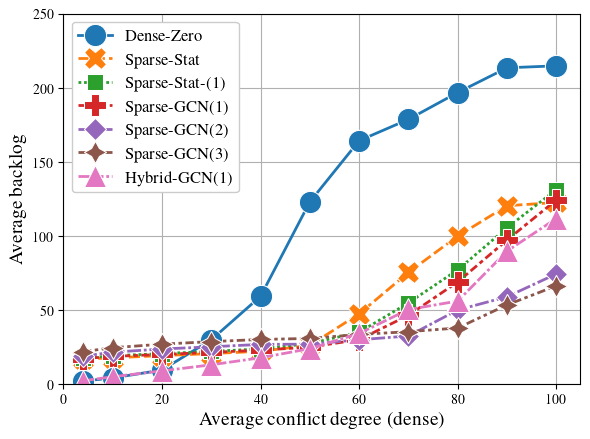

In [26]:
item = 'backlog'
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(8, 6))

# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="N_p", y="avg_queue_len", hue="policy", 
             data=df[df['policy'].isin(hue_order)], 
             hue_order=hue_order,
             style="policy",
             style_order=hue_order,
             # style="scheduler",
             # style_order=['Q-CSMA', 'CSMA'],
              # ci=True,
             errorbar=None,
              linewidth=2.0, 
              palette="tab10", 
              markers=True,
              markersize=16,
              ax=ax,
              # alpha=0.5,
              # mfc="None", mew=2,
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(fontsize=12, ncol=1)
ax.grid(True)
# ax.legend(labels=['Dense LGS', 'Sparse Stat', 'Sparse GCN'])
# labels = ['Dense LGS', 'Sparse Stat', 'Sparse GCN']
# for idx in range(len(labels)):
#     L.get_texts()[idx].set_text(labels[idx])
ax.set_ylim([0, 250])
ax.set_xlim([0, None])
ax.set_ylabel('Average backlog', fontsize=14)
ax.set_xlabel('Average conflict degree (dense)', fontsize=14)
# fontsize = 14
# for axitem in ([ax.title] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     axitem.set_fontsize(fontsize)


# fname= os.path.join('./output/', 'sparse_wireless_{}_level_{:.2f}_load_{:.2f}_er_{}_opt5_{}_{}'.format(
#     item, level, load, experiment, postfix, graphtype).replace('.','_'))
fname= os.path.join('./output/', 'sparse_wireless_{}_level_{:.2f}_load_{:.2f}_er_{}_opt9_{}_{}'.format(
    item, level, load, experiment, postfix, graphtype).replace('.','_'))
fname = fname + '.pdf'
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout()
fig.savefig(fname,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')
fig.savefig(fname.replace('.pdf','.eps'), 
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            pad_inches=0.01,
            bbox_inches='tight',
            format='eps')

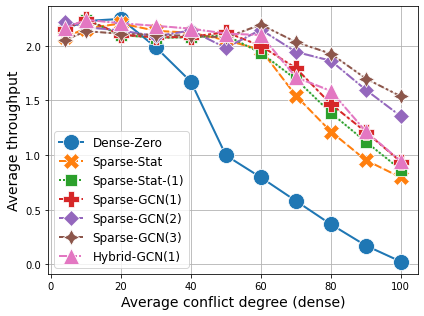

In [12]:
item = 'throughput'
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(8, 6))
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="N_p", y="avg_throughput", hue="policy", 
             data=df[df['policy'].isin(hue_order)], 
             hue_order=hue_order,
             style="policy",
             style_order=hue_order,
#              style="scheduler",
#              style_order=['Q-CSMA', 'CSMA'],
              ci=True,
              linewidth=2.0, 
              palette="tab10", 
              markers=True,
              markersize=16,
              ax=ax,
              # alpha=0.5,
              # mfc="None", mew=2,
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(fontsize=12)
ax.grid(True)
# ax.legend(labels=['Dense LGS', 'Sparse Stat', 'Sparse GCN'])
# labels = ['Dense LGS', 'Sparse Stat', 'Sparse GCN']
# for idx in range(len(labels)):
#     L.get_texts()[idx].set_text(labels[idx])
ax.set_ylabel('Average throughput', fontsize=14)
ax.set_xlabel('Average conflict degree (dense)', fontsize=14)

# fname= os.path.join('./output/', 'sparse_wireless_{}_level_{:.2f}_load_{:.2f}_er_{}_opt5_{}_{}'.format(
#     item, level, load, experiment, postfix, graphtype).replace('.','_'))
fname= os.path.join('./output/', 'sparse_wireless_{}_level_{:.2f}_load_{:.2f}_er_{}_opt9_{}_{}'.format(
    item, level, load, experiment, postfix, graphtype).replace('.','_'))
fname = fname + '.pdf'
fig.set_size_inches(6, 4.5)
plt.tight_layout()
# fig.savefig(fname,
#             dpi=300,
#             bbox_inches='tight',
#             pad_inches=0.02,
#             orientation='portrait',
#             format='pdf')


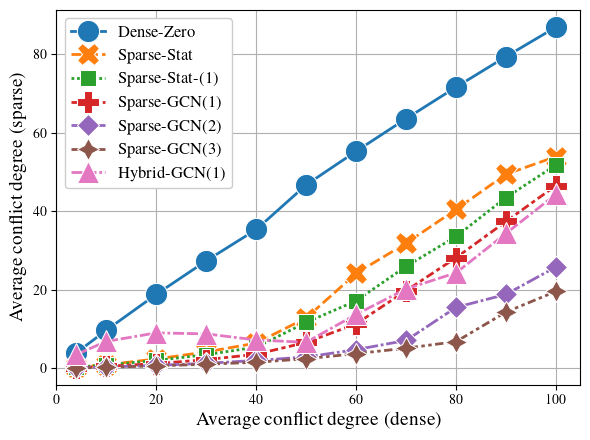

In [27]:
item = 'degree'
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(8, 6))
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="N_p", y="avg_deg_sp", hue="policy", 
             data=df[df['policy'].isin(hue_order)], 
             hue_order=hue_order,
             style="policy",
             style_order=hue_order,
             # style="scheduler",
             # style_order=['Q-CSMA', 'CSMA'],
              # ci=True,
             errorbar=None,
              linewidth=2.0, 
              palette="tab10", 
              markers=True,
              markersize=16,
              ax=ax,
              # alpha=0.5,
              # mfc="None", mew=2,
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(fontsize=12)
ax.grid(True)
ax.set_xlim([0, None])
# ax.legend(labels=['Dense LGS', 'Sparse Stat', 'Sparse GCN'])
# labels = ['Dense LGS', 'Sparse Stat', 'Sparse GCN']
# for idx in range(len(labels)):
#     L.get_texts()[idx].set_text(labels[idx])
ax.set_ylabel('Average conflict degree (sparse)', fontsize=14)
ax.set_xlabel('Average conflict degree (dense)', fontsize=14)
# fname= os.path.join(
#     './output/', 
#     'sparse_wireless_{}_level_{:.2f}_load_{:.2f}_er_{}_opt5_{}_{}'.format(
#         item, level, load, experiment, postfix, graphtype).replace('.','_'))
fname= os.path.join(
    './output/', 
    'sparse_wireless_{}_level_{:.2f}_load_{:.2f}_er_{}_opt9_{}_{}'.format(
        item, level, load, experiment, postfix, graphtype).replace('.','_'))
fname = fname + '.pdf'
fig.set_size_inches(6, 4.5)
plt.tight_layout()
fig.savefig(fname,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')
fig.savefig(fname.replace('.pdf','.eps'), 
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            pad_inches=0.01,
            bbox_inches='tight',
            format='eps')


In [319]:
df_dense = df[df['name']=='Dense-LGS']
df_dense['avg_deg_sp']

0       12.426000
3       12.565000
6       12.475000
9       12.531000
12      12.438000
          ...    
2985    10.393333
2988     9.973333
2991    10.366667
2994     9.796667
2997    10.123333
Name: avg_deg_sp, Length: 1000, dtype: float64

In [321]:
df_tmp.loc[df_tmp['name']=='Dense-LGS', 'avg_deg_sp']

Series([], Name: avg_deg_sp, dtype: float64)

In [22]:
df.groupby(['N_p'])['N'].unique()

N_p
2.0      [100, 150, 200, 250, 300]
5.0      [100, 150, 200, 250, 300]
10.0     [100, 150, 200, 250, 300]
15.0     [100, 150, 200, 250, 300]
20.0     [100, 150, 200, 250, 300]
25.0    [1000, 300, 400, 500, 750]
30.0    [1000, 300, 400, 500, 750]
35.0    [1000, 300, 400, 500, 750]
40.0    [1000, 300, 400, 500, 750]
45.0    [1000, 300, 400, 500, 750]
50.0    [1000, 300, 400, 500, 750]
Name: N, dtype: object

In [231]:
df.loc[df['graph']=='ER_n1000_p0.025_b0_uni.mat']

,graph,seed,load,name,avg_queue_len,50p_queue_len,95p_queue_len,avg_throughput,avg_n_ratio,avg_e_ratio,...,avg_bst_ratio,avg_utility,avg_degree,avg_slot,q_avg,corr,p_val,csv,N_p,N
0,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Dense-LGS,18.208760,16.2025,45.0,3.890715,0.995000,0.995000,...,1.000000,1.000000,24.852,0.983014,18.208760,0.844855,2.334378e-273,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
1,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-Stat,21.779205,20.2025,50.0,3.876280,0.325795,0.107328,...,0.335375,0.885260,24.852,1.293707,21.779205,0.693785,1.941141e-144,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
2,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-Stat-local,19.136465,17.3125,46.0,3.887165,0.514060,0.266370,...,0.524451,0.956553,24.852,1.211698,NaN,NaN,NaN,NaN,25.0,1000
3,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-GCN(1),24.674105,23.1100,56.0,3.862730,0.233485,0.052076,...,0.247915,0.829587,24.852,1.335030,24.674105,0.787369,7.023451e-212,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
4,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-GCN(1)-local,20.083975,18.3200,48.0,3.881695,0.401925,0.156145,...,0.422308,0.929287,24.852,1.264305,20.083975,0.808093,1.289581e-231,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
5500,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Dense-LGS,18.208760,16.2025,45.0,3.890715,0.995000,0.995000,...,1.000000,1.000000,24.852,0.983014,18.208760,0.844855,2.334378e-273,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
5501,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-Stat,21.779205,20.2025,50.0,3.876280,0.325795,0.107328,...,0.335375,0.885260,24.852,1.293707,21.779205,0.693785,1.941141e-144,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
5502,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-Stat-local,19.136465,17.3125,46.0,3.887165,0.514060,0.266370,...,0.524451,0.956553,24.852,1.211698,NaN,NaN,NaN,NaN,25.0,1000
5503,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-GCN(1),24.674105,23.1100,56.0,3.862730,0.233485,0.052076,...,0.247915,0.829587,24.852,1.335030,24.674105,0.787369,7.023451e-212,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000
5504,ER_n1000_p0.025_b0_uni.mat,1400194,0.08,Sparse-GCN(1)-local,20.083975,18.3200,48.0,3.881695,0.401925,0.156145,...,0.422308,0.929287,24.852,1.264305,20.083975,0.808093,1.289581e-231,sparse_schedule_queue_by_link_graph-ER_n1000_p...,25.0,1000


In [30]:
# !mkdir ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_SPAFooF1v9_l1_level-0.66_load-0.03
# !mkdir ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_SPAFooF1v9_l2_level-0.66_load-0.03
# !mkdir ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_SPAFooF1v9_l3_level-0.66_load-0.03

In [31]:
# !cp ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_ASGDF1v7_l1_level-0.66_load-0.03/config.json ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_SPAFooF1v9_l1_level-0.66_load-0.03/
# !cp ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_ASGDF1v7_l2_level-0.66_load-0.03/config.json ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_SPAFooF1v9_l2_level-0.66_load-0.03/
# !cp ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_ASGDF1v7_l3_level-0.66_load-0.03/config.json ./wireless/BA_Graph_Uniform_GEN24_test2_deadline_SPAFooF1v9_l3_level-0.66_load-0.03/


In [61]:
# !cp ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-0.66_sparsify_deadline_BA_Graph_Uniform_GEN24_test2_ASGDF1v7.csv ./wireless/metric_vs_load_summary_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-0.66_sparsify_deadline_BA_Graph_Uniform_GEN24_test2_SPAFooF1v9.csv



In [2]:
# !cp ./wireless/BA_Graph_Uniform_GEN24_m40_qcsma_ASGDF1v7_l1_level-0.75_load-0.03/*.csv ./wireless/BA_Graph_Uniform_GEN24_m40_csma_ASGDF1v7_l1_level-0.75_load-0.03/
# !cp ./wireless/BA_Graph_Uniform_GEN24_m40_qcsma_ASGDF1v7_l2_level-0.75_load-0.03/*.csv ./wireless/BA_Graph_Uniform_GEN24_m40_csma_ASGDF1v7_l2_level-0.75_load-0.03/
# !cp ./wireless/BA_Graph_Uniform_GEN24_m40_qcsma_ASGDF1v7_l3_level-0.75_load-0.03/*.csv ./wireless/BA_Graph_Uniform_GEN24_m40_csma_ASGDF1v7_l3_level-0.75_load-0.03/
